In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import io
from PIL import Image
from IPython.display import Image as IPyImage
from tqdm import tqdm
from progressbar import progressbar

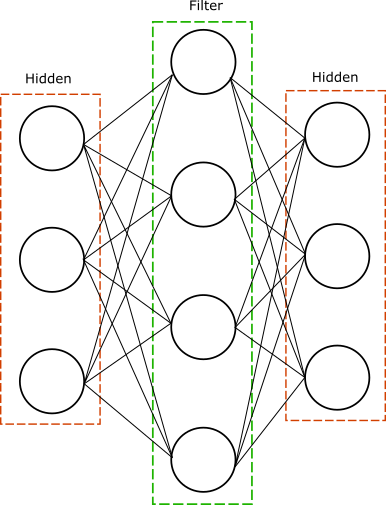

In [3]:
IPyImage('FFN.png')

In [2]:
class FFN(nn.Module):
    def __init__(self,embed_dim,filter_dim, drop_rate):
        super(FFN,self).__init__()
        
        self.embed_dim=embed_dim
        self.filter_dim=filter_dim
        self.drop_rate=drop_rate
        
        self.layer_1=nn.Linear(embed_dim,filter_dim)
        self.relu=nn.ReLU()
        self.drop=nn.Dropout(drop_rate)
        self.layer_2=nn.Linear(filter_dim,embed_dim)
        
    def forward(self,x):
        
        out=self.layer_1(x)
        out=self.relu(out)
        out=self.drop(out)
        out=self.layer_2(out)
        
        return out

In [ ]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = self.scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o
        
    @staticmethod
    def scaled_dot_product(q, k, v, mask=None):
        _k = q.size()[-1]
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        attn_logits = attn_logits / math.sqrt(d_k)
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
        attention = F.softmax(attn_logits, dim=-1)
        values = torch.matmul(attention, v)
        return values, attention

In [3]:
""" class MultiHeadAttention(nn.Module):
    
    def __init__(self,embed_dim,drop_rate,num_heads=2):
        super(MultiHeadAttention,self).__init__()
        
        self.embed_dim=embed_dim
        self.drop_rate=drop_rate
        self.num_heads=num_heads
        
        self.attention_size=embed_dim//num_heads
        self.scale=1/np.sqrt(embed_dim//num_heads)
        
        self.Q = nn.Linear(embed_dim, num_heads * self.attention_size, bias=False)
        self.K = nn.Linear(embed_dim, num_heads * self.attention_size, bias=False)
        self.V = nn.Linear(embed_dim, num_heads * self.attention_size, bias=False)
        
        self.drop=nn.Dropout(drop_rate)
        
        self.layer_out=nn.Linear(num_heads * self.attention_size,embed_dim, bias=False)
        
    def forward(self,Q,K,V, mask):
        
        batch_size=Q.size(0)
        d_K=self.attention_size
        d_V=self.attention_size
        
        q=self.Q(Q)
        q=q.view(batch_size,-1,self.num_heads,d_K) # [batch_size,Q_len,heads,d_K]
        k=self.K(K)
        k=k.view(batch_size,-1,self.num_heads,d_K) # [batch_size,K_len,heads,d_K]
        v=self.K(V)
        v=v.view(batch_size,-1,self.num_heads,d_V) # [batch_size,K_len,heads,d_K]
        
        q=q.transpose(1,2) # [batch_size,heads, K_len,d_K]
        k=k.transpose(1, 2).transpose(2, 3)
        v=v.transpose(1,2) # [batch_size,heads, K_len,d_K]
        
        out=self.scale*torch.matmul(q,k) # [batch_size,heads,Q_len,K_len]
        out=out.masked_fill(mask, float('-inf'))
        out=torch.softmax(out,dim=3) #along K_len
        out=self.drop(out)

        out=torch.matmul(out,v) # [batch_size,heads,Q_len, d_V]
        out=out.transpose(1,2).contiguous()
        out=out.view(batch_size,-1,self.num_heads*d_V)
        
        out=self.layer_out(out)
        
        return out """

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [ ]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [ ]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

In [4]:
""" class EncoderLayer(nn.Module):
    
    def __init__(self,embed_dim, filter_dim,num_heads,drop_rate):
        super(EncoderLayer,self).__init__()
        
        self.embed_dim=embed_dim
        self.filter_dim=filter_dim
        self.drop_rate=drop_rate
        
        self.layer_norm=nn.LayerNorm(embed_dim, eps=1e-6)
        self.multi_head=MultiHeadAttention(embed_dim,drop_rate,num_heads)
        self.drop=nn.Dropout(drop_rate)
        
        # feed forward network
        self.layer_norm_ffn=nn.LayerNorm(embed_dim, eps=1e-6)
        self.ffn=FFN(embed_dim,filter_dim,drop_rate)
        self.drop_ffn=nn.Dropout(drop_rate)
        
    
    def forward(self,x,mask):
        
        y=self.layer_norm(x)
        y=self.multi_head(y,y,y,mask)
        y=self.drop(y)
        y=y+x
        
        #ffn
        
        z=self.layer_norm_ffn(y)
        z=self.ffn(z)
        z=self.drop_ffn(z)
        z=z+y
        
        return z """

In [5]:
class DecoderLayer(nn.Module):
    
    def __init__(self,embed_dim,filter_dim,num_heads,drop_rate):
        super(DecoderLayer,self).__init__()
        
        self.embed_dim=embed_dim
        self.filter_dim=filter_dim
        self.drop_rate=drop_rate
        
        self.layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
        self.multi_head=MultiHeadAttention(embed_dim,drop_rate,num_heads)
        self.drop=nn.Dropout(drop_rate)
        
        self.enc_dec_layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
        self.enc_dec_multi_head=MultiHeadAttention(embed_dim,drop_rate,num_heads)
        self.enc_dec_drop=nn.Dropout(drop_rate)
        
        self.layer_norm_ffn=nn.LayerNorm(embed_dim, eps=1e-6)
        self.ffn=FFN(embed_dim,filter_dim,drop_rate)
        self.drop_ffn=nn.Dropout(drop_rate)
        
        def forward(self,x,encoded, mask_1,mask_2):
            
            y=self.layer_norm(x)
            y=self.multi_head(y,y,y,mask_1)
            y=self.drop(y)
            
            y=x+y
            
            if encoded is not None:
                z=self.enc_dec_layer_norm(y)
                z=self.enc_dec_multi_head(y,encoded,encoded,mask_2)
                z=self.enc_dec_drop(z)
                z=self.enc_dec_drop(z)
                
                z=z+y
            
            w=self.layer_norm_ffn(z)
            w=self.ffn(w)
            w=self.drop_ffn(w)
            
            w=w+z
            
            return w

In [6]:
class Encoder(nn.Module):
    
    def __init__(self,embed_dim,filter_dim,drop_rate,n_layers,num_heads):
        super(Encoder,self).__init__()
        
        encoders=[EncoderLayer(embed_dim,filter_dim,num_heads,drop_rate) for _ in range(n_layers)]
        self.encoders=nn.ModuleList(encoders)
        self.layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
        
    def forward(self,x,mask):
        out=x
        for layer in self.encoders:
            out=layer(out,mask)
        return self.layer_norm(out)
    
class Decoder(nn.Module):
    
    def __init__(self,embed_dim,filter_dim,drop_rate,n_layers,num_heads):
        super(Decoder,self).__init__()
        
        decoders=[DecoderLayer(embed_dim,filter_dim,num_heads,drop_rate) for _ in range(n_layers)]
        self.decoders=nn.ModuleList(decoders)
        self.layer_norm=nn.LayerNorm(embed_dim,eps=1e-6)
        
    def forward(self, targets, encoded, mask_1,mask_2):
        out = targets
        for dec_layer in self.decoders:
            out = dec_layer(out, encoded, mask2, mask1)
        return self.last_norm(out)

In [26]:
class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim, dropout_rate=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)

        pe = torch.zeros(max_len, embed_dim) # [max_len,embed_dim]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # use regiter_buffer so this tensor is not updated under training
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [:,embed_dim]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Transformer for Text Generation

In [24]:
class Transformer(nn.Module):
    # For text generation, input vocab= target vocab
    def __init__(self,vocab_size,n_layers,embed_dim,filter_dim,num_heads,dropout_rate):
        super(Transformer,self).__init__()
            
        self.vocab_size=vocab_size
        self.embed_dim=embed_dim
        self.filter_dim=filter_dim
        
        self.embedding=nn.Embedding(vocab_size,embed_dim)
        self.encoder=Encoder(embed_dim,filter_dim,dropout_rate,n_layers,num_heads)
        self.decoder=nn.Linear(embed_dim,vocab_size)

        self.pos=PositionalEncoding(embed_dim,dropout_rate)
    
    def forward(self,x,mask):
        
        x_embed=self.embedding(x)*math.sqrt(self.embed_dim)
        x_pos=self.pos(x_embed)
        x_encoded=self.encoder(x_pos,mask)
        x_decoded=self.decoder(x_encoded)
        
        return x_decoded

# Training

In [9]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [10]:
test_filepath='.data/wikitext-2/wiki.test.tokens'
valid_filepath='.data/wikitext-2/wiki.valid.tokens'
train_filepath= '.data/wikitext-2/wiki.train.tokens'

In [11]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer,iter(io.open(train_filepath,encoding="utf8"))))

36718lines [00:01, 20940.56lines/s]


In [ ]:
vocab.stoi

In [12]:
def data_process(raw_text_iter):
  data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                       dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

In [13]:
train_data = data_process(iter(io.open(train_filepath, encoding="utf8")))
val_data = data_process(iter(io.open(valid_filepath, encoding="utf8")))
test_data = data_process(iter(io.open(test_filepath, encoding="utf8")))

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [16]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [122]:
vocab_size = len(vocab.stoi) # the size of vocabulary
embed_dim = 200 # embedding dimension
filter_dim = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
n_layers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
num_heads = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = Transformer(vocab_size,n_layers, embed_dim,filter_dim,num_heads,dropout).to(device)

In [30]:
def generate_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    
    return ~mask

In [111]:
def train(model,criterion,optimizer, train_data,epochs):
    
    for epoch in range(epochs):
        model.train()
        total_loss=0
        src_mask=generate_mask(bptt).to(device)
        for i in progressbar(range(0, train_data.size(0) - 1, bptt)):
            data, targets = get_batch(train_data, i)
            optimizer.zero_grad()
            if data.size(0) != bptt:
                src_mask = generate_mask(data.size(0)).to(device)
            output = model(data.T, src_mask)
            loss = criterion(output.view(-1, vocab_size), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print('epoch: ',epoch,', Loss: ',total_loss/train_data.size(0))

In [123]:
criterion = nn.CrossEntropyLoss()
lr = 3.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [126]:
train(model,criterion,optimizer,train_data,10)

100% (2929 of 2929) |####################| Elapsed Time: 0:00:38 Time:  0:00:38
  0% (9 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:34

epoch:  0 , Loss:  0.1915034749282067


100% (2929 of 2929) |####################| Elapsed Time: 0:00:38 Time:  0:00:38
  0% (9 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:34

epoch:  1 , Loss:  0.19086674898931166


100% (2929 of 2929) |####################| Elapsed Time: 0:00:37 Time:  0:00:37
  0% (9 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:35

epoch:  2 , Loss:  0.19033246433494497


100% (2929 of 2929) |####################| Elapsed Time: 0:00:37 Time:  0:00:37
  0% (8 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:38

epoch:  3 , Loss:  0.18974748692545867


100% (2929 of 2929) |####################| Elapsed Time: 0:00:37 Time:  0:00:37
  0% (8 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:41

epoch:  4 , Loss:  0.18913434315409783


100% (2929 of 2929) |####################| Elapsed Time: 0:00:37 Time:  0:00:37
  0% (9 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:34

epoch:  5 , Loss:  0.18857894826618526


100% (2929 of 2929) |####################| Elapsed Time: 0:00:37 Time:  0:00:37
  0% (8 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:37

epoch:  6 , Loss:  0.18805452684042895


100% (2929 of 2929) |####################| Elapsed Time: 0:00:38 Time:  0:00:38
  0% (8 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:41

epoch:  7 , Loss:  0.18746501500027885


100% (2929 of 2929) |####################| Elapsed Time: 0:00:38 Time:  0:00:38
  0% (8 of 2929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:40

epoch:  8 , Loss:  0.18699186953741484


100% (2929 of 2929) |####################| Elapsed Time: 0:00:38 Time:  0:00:38


epoch:  9 , Loss:  0.18649346193981958


In [92]:
def eval_model(model,data_source):
    model.eval()
    
    src_mask=generate_mask(bptt).to(device)
    acc=0
    n=0
    for i in progressbar(range(0, data_source.size(0) - 1, bptt)):
        data, targets = get_batch(data_source, i)
        if data.size(0) != bptt:
            src_mask = generate_mask(data.size(0)).to(device)
        output=model(data.T, src_mask)
        output=output.view(-1, vocab_size)
        prob=F.softmax(output,dim=-1)
        pred=prob.argmax(dim=-1)
        acc+=(pred==targets).sum().item()
        n+=data.size(0)
    
    n=n*20
    print('accuracy: ',acc/n)

In [127]:
eval_model(model,train_data)

100% (2929 of 2929) |####################| Elapsed Time: 0:00:16 Time:  0:00:16


accuracy:  0.050020976019044275


In [72]:
x=torch.Tensor([1,0])

In [78]:
x.sum().item()

1.0

In [109]:
model.eval()
src_mask=generate_mask(bptt).to(device)
acc=0
n=0
for i in progressbar(range(0, train_data.size(0) - 1, bptt)):
    data, targets = get_batch(train_data, i)
    if data.size(0) != bptt:
        src_mask = generate_mask(data.size(0)).to(device)
    output=model(data.T, src_mask)
    output=output.view(-1, vocab_size)
    prob=F.softmax(output,dim=-1)
    pred=prob.argmax(dim=-1)
    acc+=(pred==targets).sum().item()
    
    break

N/A% (0 of 2929) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

In [107]:
data.size()

torch.Size([35, 20])